In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [7]:
from astir.data import from_csv_yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import metrics

# 1st Level - CL

In [3]:
expression_mat_path= 'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL_scaled.csv'
yaml_marker_path = "C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\cell_type_descr_astir.yml"

In [4]:
ast = from_csv_yaml(expression_mat_path, marker_yaml=yaml_marker_path)
print(ast)

Astir object, 4 cell types, 80057 cells


c:\Users\Localadmin_kangzigi\.conda\envs\astir\lib\site-packages\astir\data\data_readers.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_gex = pd.read_csv(csv_input, index_col=0)


In [5]:
ast.fit_type(max_epochs=10, n_init=3, n_init_epochs=2)

training restart (final):  60%|██████    | 6/10 [ 3.77s/epochs, current loss: -1564519.3]


In [6]:
cell_types = ast.get_celltypes()
print(len(np.unique(cell_types)))

6


<Axes: >

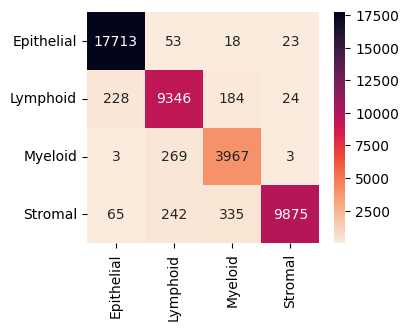

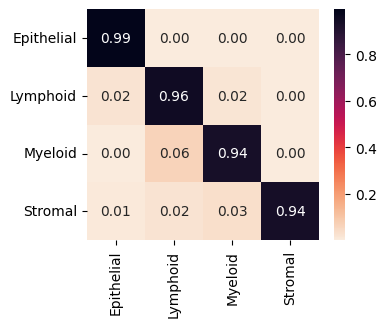

In [18]:
# "original_labels" list of the "ground_truth labels"

sample_data = pd.read_csv(expression_mat_path,low_memory=False)
original_labels = np.array(sample_data["cell_type_upperlevel"]).tolist()
astrir_labels = list(cell_types["cell_type"])
original_label_types = np.unique(original_labels)
tribus_labels = [ 'other_Global' if label == 'Unknown' or label == 'Other' else label for label in astrir_labels]

cm = metrics.confusion_matrix(original_labels, astrir_labels, labels=original_label_types)
df_cm = pd.DataFrame(cm, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(astrir_labels))*0.625, len(np.unique(astrir_labels))*0.5))         # Sample figsize in inches
sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cmn = pd.DataFrame(cmn, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(astrir_labels))*0.625, len(np.unique(astrir_labels))*0.5)) 
sns.heatmap(df_cmn, fmt=".2f", annot=True, cmap=sns.cm.rocket_r)


# 1st Level - SB

In [28]:
expression_mat_path= 'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_SB_scaled.csv'
yaml_marker_path = "C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\cell_type_descr_astir.yml"

In [29]:
ast = from_csv_yaml(expression_mat_path, marker_yaml=yaml_marker_path)
print(ast)

Astir object, 4 cell types, 100993 cells


c:\Users\Localadmin_kangzigi\.conda\envs\astir\lib\site-packages\astir\data\data_readers.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_gex = pd.read_csv(csv_input, index_col=0)


In [30]:
ast.fit_type(max_epochs=10, n_init=3, n_init_epochs=2)

training restart (final):  40%|████      | 4/10 [ 5.36s/epochs, current loss: -2148878.5]


In [31]:
cell_types = ast.get_celltypes()
print(len(np.unique(cell_types)))

6


<Axes: >

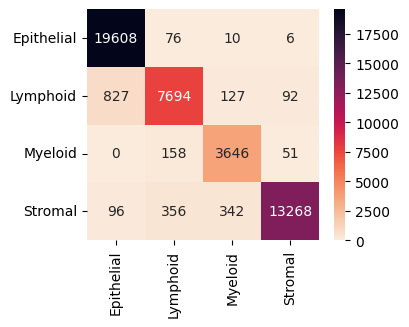

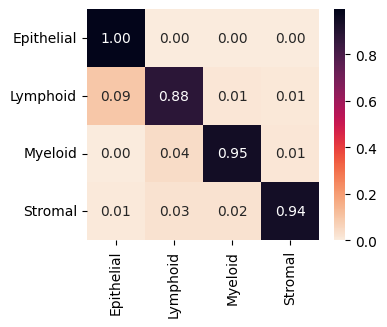

In [32]:
# "original_labels" list of the "ground_truth labels"

sample_data = pd.read_csv(expression_mat_path,low_memory=False)
original_labels = np.array(sample_data["cell_type_upperlevel"]).tolist()
astrir_labels = list(cell_types["cell_type"])
original_label_types = np.unique(original_labels)
tribus_labels = [ 'other_Global' if label == 'Unknown' or label == 'Other' else label for label in astrir_labels]

cm = metrics.confusion_matrix(original_labels, astrir_labels, labels=original_label_types)
df_cm = pd.DataFrame(cm, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(astrir_labels))*0.625, len(np.unique(astrir_labels))*0.5))         # Sample figsize in inches
sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cmn = pd.DataFrame(cmn, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(astrir_labels))*0.625, len(np.unique(astrir_labels))*0.5)) 
sns.heatmap(df_cmn, fmt=".2f", annot=True, cmap=sns.cm.rocket_r)


# 2nd level

In [20]:
expression_mat_path= 'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL_scaled.csv'
yaml_marker_path = "C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\cell_type_descr_astir_2lelvel.yml"

In [21]:
ast = from_csv_yaml(expression_mat_path, marker_yaml=yaml_marker_path)
print(ast)

Astir object, 14 cell types, 80057 cells


c:\Users\Localadmin_kangzigi\.conda\envs\astir\lib\site-packages\astir\data\data_readers.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_gex = pd.read_csv(csv_input, index_col=0)


In [22]:
ast.fit_type(max_epochs=10, n_init=3, n_init_epochs=2)

training restart (final): 100%|██████████| 10/10 [ 5.71s/epochs, current loss: -3049590.0]
c:\Users\Localadmin_kangzigi\.conda\envs\astir\lib\site-packages\astir\astir.py:183: UserWarning: Maximum epochs reached. More iteration may be needed to complete the training.
  warnings.warn(msg)


In [23]:
cell_types = ast.get_celltypes()
print(len(np.unique(cell_types)))

16


<Axes: >

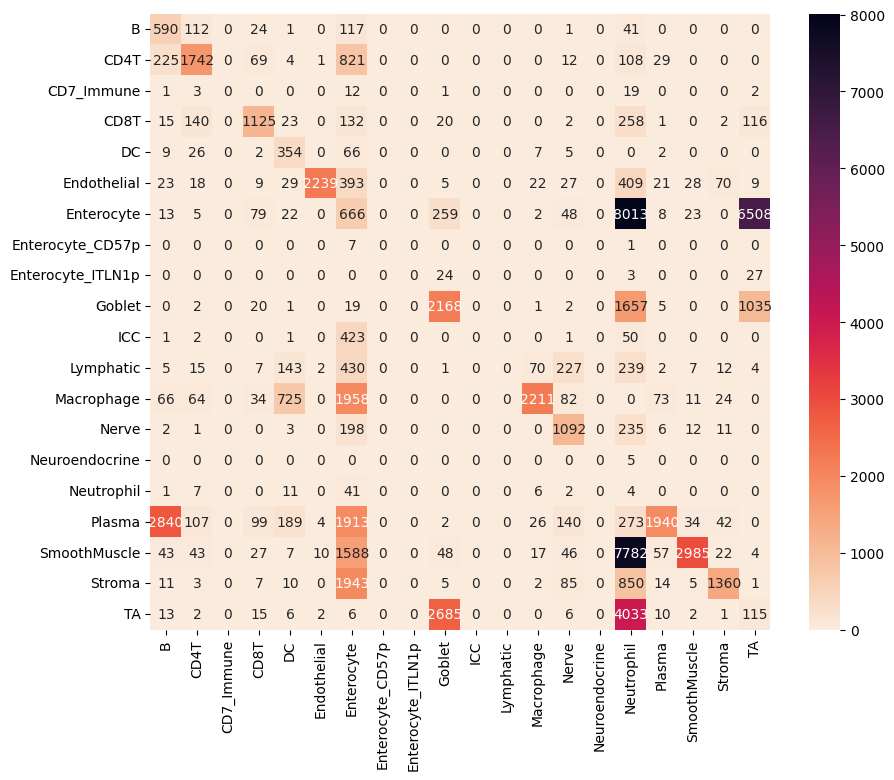

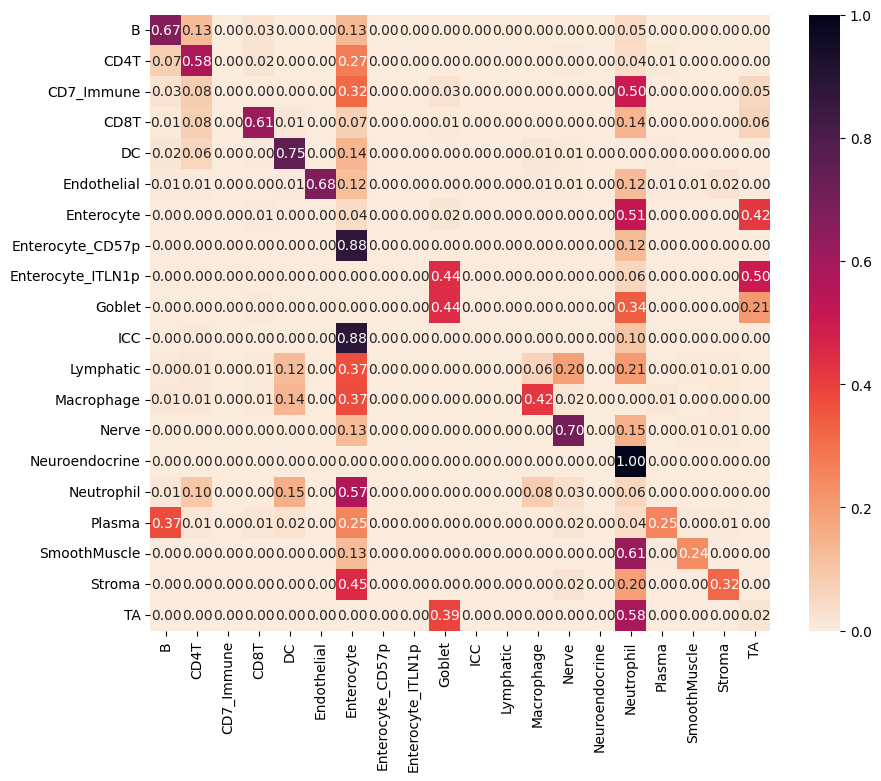

In [24]:
# "original_labels" list of the "ground_truth labels"

sample_data = pd.read_csv(expression_mat_path,low_memory=False)
original_labels = np.array(sample_data["cell_type_A"]).tolist()
astrir_labels = list(cell_types["cell_type"])
original_label_types = np.unique(original_labels)
tribus_labels = [ 'other_Global' if label == 'Unknown' or label == 'Other' else label for label in astrir_labels]

cm = metrics.confusion_matrix(original_labels, astrir_labels, labels=original_label_types)
df_cm = pd.DataFrame(cm, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(astrir_labels))*0.625, len(np.unique(astrir_labels))*0.5))         # Sample figsize in inches
sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cmn = pd.DataFrame(cmn, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(astrir_labels))*0.625, len(np.unique(astrir_labels))*0.5)) 
sns.heatmap(df_cmn, fmt=".2f", annot=True, cmap=sns.cm.rocket_r)